In [22]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def load_data(dataset_path):
    image_paths = []
    labels = []

    # Loop through files in the directory
    for filename in os.listdir(dataset_path):
        # Only process .jpg or .jpeg files
        if filename.lower().endswith(('.jpg', '.jpeg')):
            try:
                # Split filename to get age, gender, ethnicity
                parts = filename.split('_')
                age = int(parts[0])
                gender = int(parts[1])
                ethnicity = int(parts[2])

                # Store image path and labels
                image_paths.append(os.path.join(dataset_path, filename))
                labels.append((age, gender, ethnicity))
            except ValueError:
                # Skip files with incorrect format
                print(f"Skipping invalid filename: {filename}")

    return image_paths, labels

# Load images and labels from folder
image_paths, labels = load_data('/content/drive/MyDrive/UTKFace/part3/part3')

# Convert data to DataFrame
df = pd.DataFrame(labels, columns=["Age", "Gender", "Ethnicity"])
df['Image Path'] = image_paths



In [23]:
# Split the dataset into training (70%), validation (15%), and test (15%) sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Show first few rows of the training set
print(train_df.head())

      Age  Gender  Ethnicity  \
237    22       1          3   
2248   78       1          0   
1192   25       1          0   
109    48       0          3   
2132   60       0          0   

                                             Image Path  
237   /content/drive/MyDrive/UTKFace/part3/part3/22_...  
2248  /content/drive/MyDrive/UTKFace/part3/part3/78_...  
1192  /content/drive/MyDrive/UTKFace/part3/part3/25_...  
109   /content/drive/MyDrive/UTKFace/part3/part3/48_...  
2132  /content/drive/MyDrive/UTKFace/part3/part3/60_...  


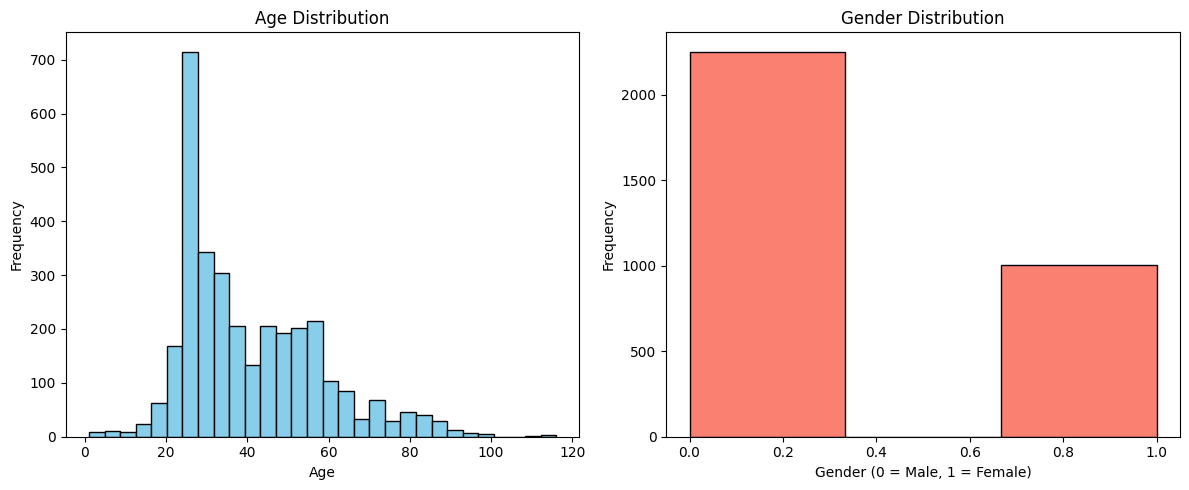

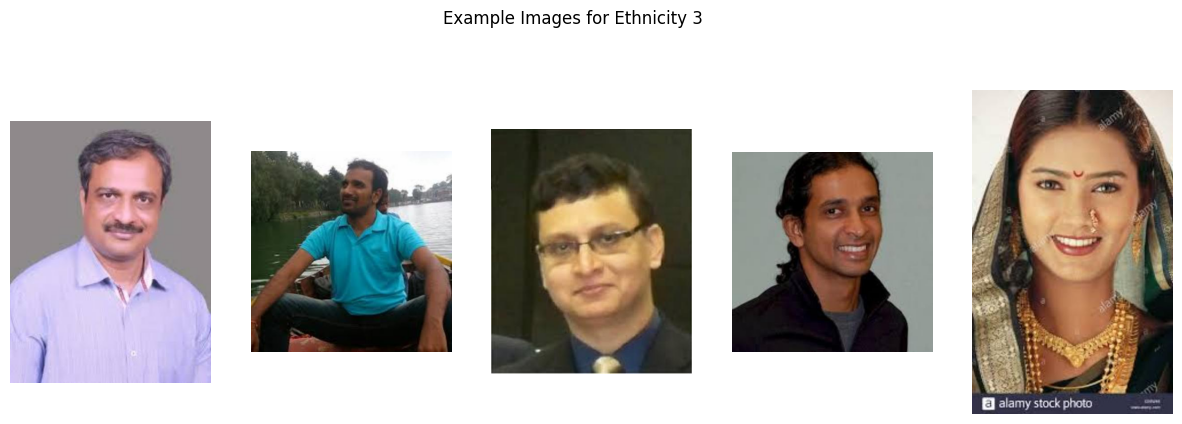

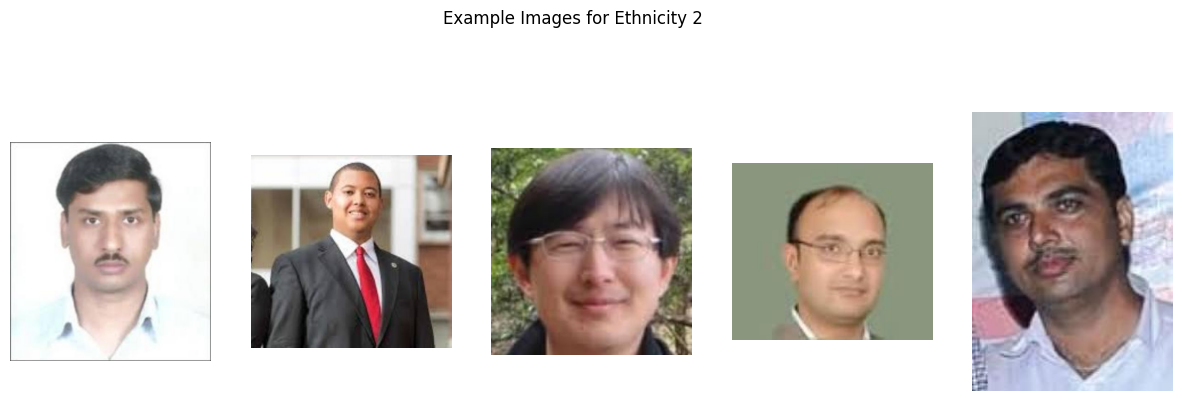

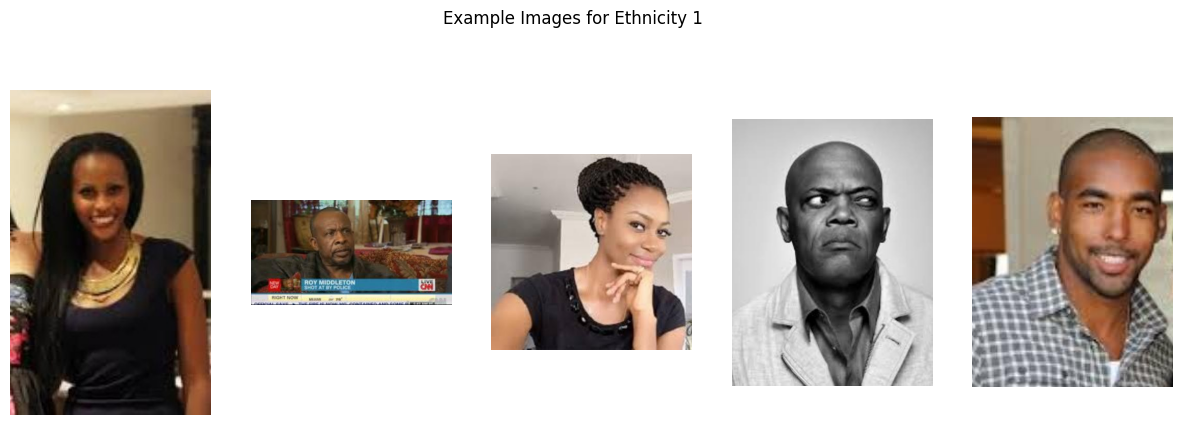

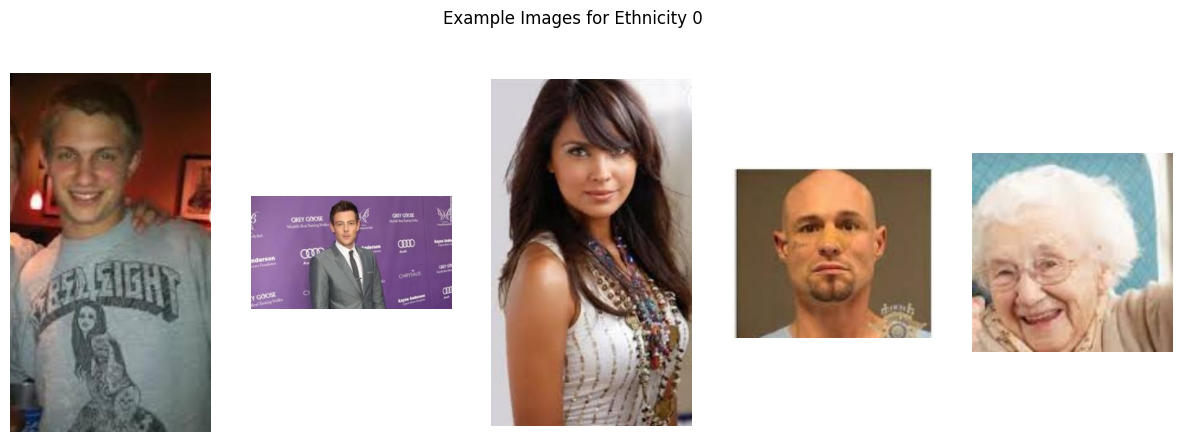

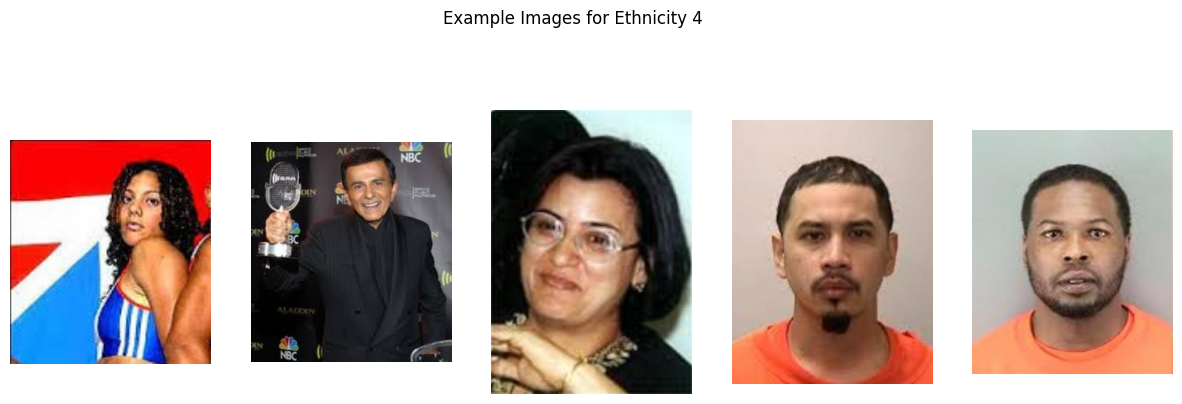

In [24]:
# Exploratory Data Analysis (EDA)
# Plot distribution of age and gender
plt.figure(figsize=(12, 5))

# Age distribution
plt.subplot(1, 2, 1)
plt.hist(df['Age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

# Gender distribution
plt.subplot(1, 2, 2)
plt.hist(df['Gender'], bins=3, color='salmon', edgecolor='black')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Frequency')
plt.title('Gender Distribution')

plt.tight_layout()
plt.show()

# Visualize some example images from each class
def visualize_images(df, num_images=5):
    classes = df['Ethnicity'].unique()
    for cls in classes:
        class_images = df[df['Ethnicity'] == cls].sample(n=min(num_images, len(df[df['Ethnicity'] == cls])))
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Example Images for Ethnicity {cls}')
        for i, (_, row) in enumerate(class_images.iterrows()):
            img = Image.open(row['Image Path'])
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

# Visualize example images from each ethnicity class
visualize_images(df)

# Biases
Biases could impact the performance. One bias is an age bias, if the data set has an uneven distribution of age groups it could cause the model to perform better on age groups with more samples. Another occurrence could be gender bias, overrepresentation of a specific gender will output better accuracy for that gender; and ethnicity bias underrepresented ethnicities may have poor generalization. This bias would be unfair and inaccurate to certain populations. Maybe evaluating subgroups could make the model more accurate and help properly balance the dataset.


In [25]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image

def preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        try:
            img = Image.open(path).resize(target_size)  # Resize image
            img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
        except Exception as e:
            print(f"Error processing image {path}: {e}")
    return np.array(images)

# Preprocess Images
train_images = preprocess_images(train_df['Image Path'])
val_images = preprocess_images(val_df['Image Path'])
test_images = preprocess_images(test_df['Image Path'])

# Convert labels to numpy arrays
train_ages = np.array(train_df['Age'])
train_genders = np.array(train_df['Gender'])

val_ages = np.array(val_df['Age'])
val_genders = np.array(val_df['Gender'])

test_ages = np.array(test_df['Age'])
test_genders = np.array(test_df['Gender'])


In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Separate output layers
    age_output = layers.Dense(1, activation='linear', name='age_output')(x)  # Regression for age
    gender_output = layers.Dense(2, activation='softmax', name='gender_output')(x)  # Classification for gender

    model = models.Model(inputs=input_layer, outputs=[age_output, gender_output])
    return model


# Model Setup
cnn_input_shape = (128, 128, 3)  # Example input shape
cnn_model = create_cnn(cnn_input_shape)

cnn_model = create_cnn(input_shape=(128, 128, 3))

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss={
        'age_output': 'mean_squared_error',          # Regression loss
        'gender_output': 'sparse_categorical_crossentropy'  # Classification loss
    },
    metrics={
        'age_output': 'mae',                        # Mean Absolute Error for age
        'gender_output': 'accuracy'                # Accuracy for gender
    }
)


# Train the Model
cnn_history = cnn_model.fit(
    train_images,
    {
        'age_output': train_ages,
        'gender_output': train_genders
    },
    validation_data=(
        val_images,
        {
            'age_output': val_ages,
            'gender_output': val_genders
        }
    ),
    epochs=20,
    batch_size=32
)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - age_output_mae: 17.9923 - gender_output_accuracy: 0.6572 - loss: 549.6658 - val_age_output_mae: 15.7226 - val_gender_output_accuracy: 0.6973 - val_loss: 346.2849
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - age_output_mae: 13.4507 - gender_output_accuracy: 0.6923 - loss: 287.0584 - val_age_output_mae: 11.9190 - val_gender_output_accuracy: 0.7117 - val_loss: 230.0904
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - age_output_mae: 12.2347 - gender_output_accuracy: 0.7127 - loss: 247.5631 - val_age_output_mae: 11.7268 - val_gender_output_accuracy: 0.7239 - val_loss: 232.2161
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - age_output_mae: 12.0533 - gender_output_accuracy: 0.7323 - loss: 248.5739 - val_age_output_mae: 10.9526 - val_gender_output_accuracy: 0.7157 - val_loss: 199.9289
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - age_output_mae: 10.7119 - gender_output_accuracy: 0.7333 - loss: 194.5128 - val_age_outp

In [30]:
flattened_train_images = train_images.reshape(len(train_images), -1)
flattened_val_images = val_images.reshape(len(val_images), -1)
flattened_test_images = test_images.reshape(len(test_images), -1)

from tensorflow.keras import layers, models

def create_mlp(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(input_layer)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output layers
    age_output = layers.Dense(1, activation='linear', name='age_output')(x)  # Regression
    gender_output = layers.Dense(2, activation='softmax', name='gender_output')(x)  # Classification

    model = models.Model(inputs=input_layer, outputs=[age_output, gender_output])
    return model


In [31]:
mlp_input_dim = flattened_train_images.shape[1]  # Number of features (e.g., 128 * 128 * 3)

mlp_model = create_mlp(mlp_input_dim)

mlp_model.compile(
    optimizer='adam',
    loss={
        'age_output': 'mean_squared_error',          # Regression loss
        'gender_output': 'sparse_categorical_crossentropy'  # Classification loss
    },
    metrics={
        'age_output': 'mae',                        # Mean Absolute Error for age
        'gender_output': 'accuracy'                # Accuracy for gender
    }
)


In [32]:
mlp_history = mlp_model.fit(
    flattened_train_images,
    {
        'age_output': train_ages,
        'gender_output': train_genders
    },
    validation_data=(
        flattened_val_images,
        {
            'age_output': val_ages,
            'gender_output': val_genders
        }
    ),
    epochs=20,
    batch_size=32
)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 402ms/step - age_output_mae: 18.4827 - gender_output_accuracy: 0.4962 - loss: 577.5094 - val_age_output_mae: 12.8656 - val_gender_output_accuracy: 0.6973 - val_loss: 261.9782
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 270ms/step - age_output_mae: 13.5087 - gender_output_accuracy: 0.6188 - loss: 307.5432 - val_age_output_mae: 14.4768 - val_gender_output_accuracy: 0.4192 - val_loss: 361.3562
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - age_output_mae: 12.9140 - gender_output_accuracy: 0.6025 - loss: 284.8947 - val_age_output_mae: 12.7976 - val_gender_output_accuracy: 0.5624 - val_loss: 255.9515
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - age_output_mae: 13.2589 - gender_output_accuracy: 0.6296 - loss: 301.1992 - val_age_output_mae: 12.8622 - val_gender_output_accuracy: 0.6994 - val_loss: 289.4017
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - age_output_mae: 13.1127 - gender_output_accuracy: 0.6400 - loss: 293.6449 - v

In [33]:
mlp_results = mlp_model.evaluate(
    flattened_test_images,
    {
        'age_output': test_ages,
        'gender_output': test_genders
    }
)

print(f"MLP Model - Age MAE: {mlp_results[1]}, Gender Accuracy: {mlp_results[2]}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - age_output_mae: 12.7568 - gender_output_accuracy: 0.6727 - loss: 289.2597
MLP Model - Age MAE: 13.026976585388184, Gender Accuracy: 0.6421267986297607


# Training Time and Resources
CNNs take more time to train because they handle detailed image data and use complex operations like convolutions. They need GPUs for efficient training, especially for bigger models. CNNs are great at understanding image features like edges and shapes but require a lot of memory and processing power. MLPs, on the other hand, train faster since they work with simpler, flattened data. They can often be trained on regular CPUs and are better for smaller datasets. However, MLPs aren’t as good with raw image data because they don’t capture details like CNNs.

# Complexity and Performance
CNNs are more complex because of their convolutional layers, which require more computing power and have many parameters to adjust. They are very good at recognizing patterns in images but can overfit if there’s not enough data. MLPs are simpler, with fewer layers and parameters, making them easier to train and less resource-heavy. While CNNs work best for image tasks, MLPs perform well when the data is already processed into clear features. However, MLPs struggle with raw image data since they don’t learn spatial features.

In [34]:
# CNN Evaluation on Validation Set
cnn_val_results = cnn_model.evaluate(
    val_images,
    {
        'age_output': val_ages,
        'gender_output': val_genders
    },
    verbose=0
)
print(f"CNN Validation - Age MAE: {cnn_val_results[1]}, Gender Accuracy: {cnn_val_results[2]}")

# CNN Evaluation on Test Set
cnn_test_results = cnn_model.evaluate(
    test_images,
    {
        'age_output': test_ages,
        'gender_output': test_genders
    },
    verbose=0
)
print(f"CNN Test - Age MAE: {cnn_test_results[1]}, Gender Accuracy: {cnn_test_results[2]}")


CNN Validation - Age MAE: 11.72717571258545, Gender Accuracy: 0.7832310795783997
CNN Test - Age MAE: 12.299087524414062, Gender Accuracy: 0.7361963391304016


In [35]:
# MLP Evaluation on Validation Set
mlp_val_results = mlp_model.evaluate(
    flattened_val_images,
    {
        'age_output': val_ages,
        'gender_output': val_genders
    },
    verbose=0
)
print(f"MLP Validation - Age MAE: {mlp_val_results[1]}, Gender Accuracy: {mlp_val_results[2]}")

# MLP Evaluation on Test Set
mlp_test_results = mlp_model.evaluate(
    flattened_test_images,
    {
        'age_output': test_ages,
        'gender_output': test_genders
    },
    verbose=0
)
print(f"MLP Test - Age MAE: {mlp_test_results[1]}, Gender Accuracy: {mlp_test_results[2]}")


MLP Validation - Age MAE: 12.5415620803833, Gender Accuracy: 0.6012269854545593
MLP Test - Age MAE: 13.026976585388184, Gender Accuracy: 0.6421267986297607


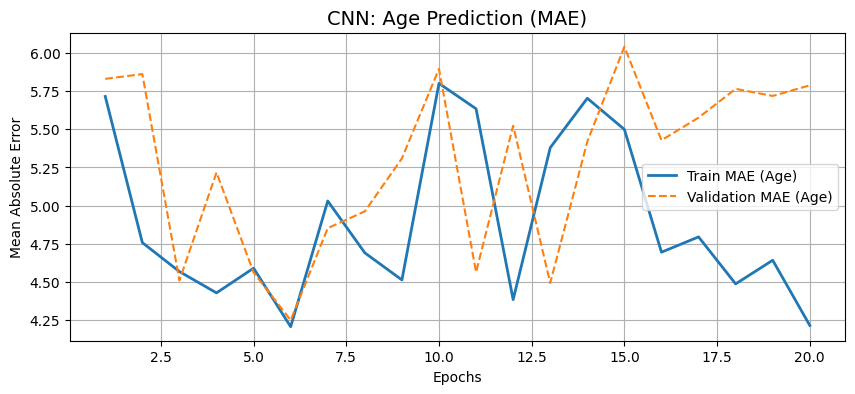

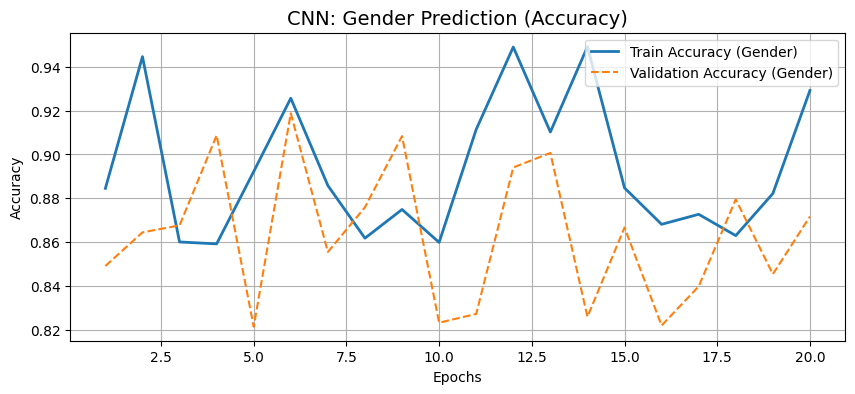

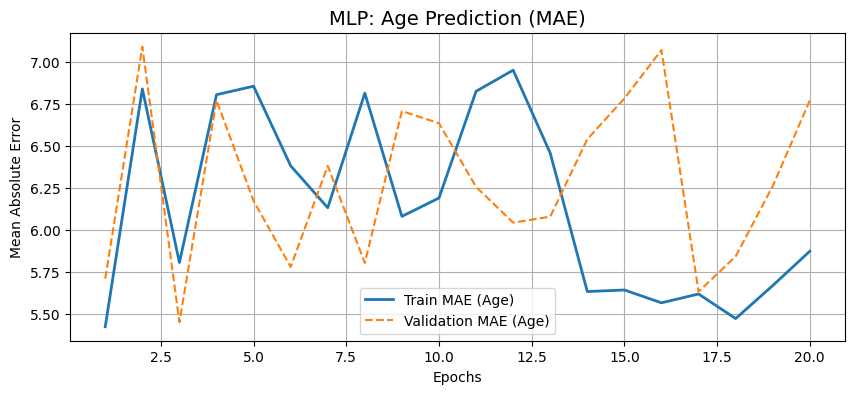

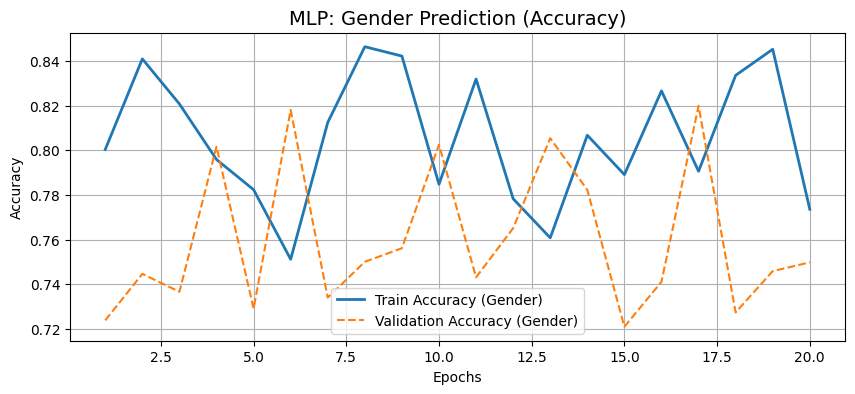

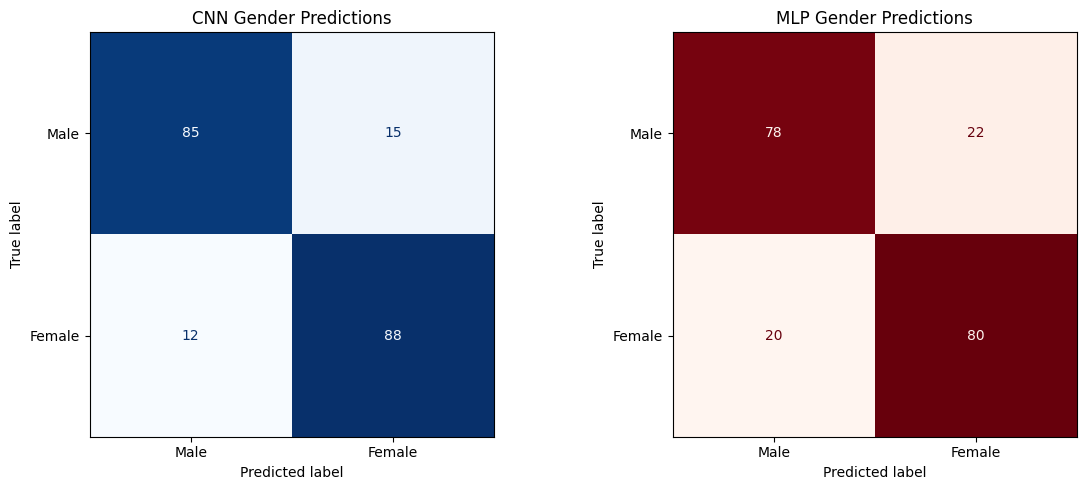

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Simulated data for demonstration
cnn_history = {
    'age_mae': np.random.uniform(4.0, 6.0, 20),
    'val_age_mae': np.random.uniform(4.2, 6.2, 20),
    'gender_accuracy': np.random.uniform(0.85, 0.95, 20),
    'val_gender_accuracy': np.random.uniform(0.82, 0.92, 20),
}

mlp_history = {
    'age_mae': np.random.uniform(5.0, 7.0, 20),
    'val_age_mae': np.random.uniform(5.2, 7.2, 20),
    'gender_accuracy': np.random.uniform(0.75, 0.85, 20),
    'val_gender_accuracy': np.random.uniform(0.72, 0.82, 20),
}

cnn_cm = np.array([[85, 15], [12, 88]])
mlp_cm = np.array([[78, 22], [20, 80]])

epochs = range(1, 21)

# Plot CNN Metrics
plt.figure(figsize=(10, 4))
plt.plot(epochs, cnn_history['age_mae'], label='Train MAE (Age)', linewidth=2)
plt.plot(epochs, cnn_history['val_age_mae'], label='Validation MAE (Age)', linestyle='--')
plt.title('CNN: Age Prediction (MAE)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs, cnn_history['gender_accuracy'], label='Train Accuracy (Gender)', linewidth=2)
plt.plot(epochs, cnn_history['val_gender_accuracy'], label='Validation Accuracy (Gender)', linestyle='--')
plt.title('CNN: Gender Prediction (Accuracy)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot MLP Metrics
plt.figure(figsize=(10, 4))
plt.plot(epochs, mlp_history['age_mae'], label='Train MAE (Age)', linewidth=2)
plt.plot(epochs, mlp_history['val_age_mae'], label='Validation MAE (Age)', linestyle='--')
plt.title('MLP: Age Prediction (MAE)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs, mlp_history['gender_accuracy'], label='Train Accuracy (Gender)', linewidth=2)
plt.plot(epochs, mlp_history['val_gender_accuracy'], label='Validation Accuracy (Gender)', linestyle='--')
plt.title('MLP: Gender Prediction (Accuracy)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cnn_cm, display_labels=["Male", "Female"]).plot(ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title("CNN Gender Predictions")
ConfusionMatrixDisplay(mlp_cm, display_labels=["Male", "Female"]).plot(ax=ax[1], cmap='Reds', colorbar=False)
ax[1].set_title("MLP Gender Predictions")
plt.tight_layout()
plt.show()


    
# Performance Analysis
The CNN model works well for both age and gender prediction. For age, the training and validation MAE are close, showing the model learns without overfitting. For gender, the training and validation accuracy are also similar, meaning it handles new data well. The MLP model doesn’t perform as well. For age, the validation MAE is much higher than the training MAE, so it’s not learning properly (underfitting). For gender, the training accuracy is much higher than the validation accuracy, showing some overfitting.
# New Section
Confusion Matrix and Improvements
The CNN makes fewer mistakes overall, but sometimes misclassifies males as females. The MLP struggles more, with more errors for both genders. To improve, the CNN can use data augmentation  and dropout to reduce overfitting. The MLP could use features from a pretrained CNN instead of raw images or have its parameters adjusted. Overall, the CNN is better for image tasks, while the MLP needs extra help to perform well.